In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [5]:
#数据处理
def dataset(data_type='train', batch_size=10):
    # 创建队列保护输入文件列表
    filename_queue = tf.train.string_input_producer(['data/data_tfrecord/' + data_type + '.tfrecords'])  
    # 读取并解析一个tfrecord
    reader = tf.TFRecordReader()  
    _, serialized_example = reader.read(filename_queue)
    example = tf.parse_single_example(serialized_example, features={
        'f1': tf.FixedLenFeature([], tf.string),
        'f2': tf.FixedLenFeature([], tf.string)})
    # 将字符串分别解析成标签和图像对应的像素组（并重组）
    image = tf.decode_raw(example['f1'], tf.float32)
    label = tf.decode_raw(example['f2'], tf.float64)
    image = tf.reshape(image, [28, 28])
    label= tf.reshape(label,[1,10])
    
    img_batch, l_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        capacity= (3 * batch_size),
        min_after_dequeue=batch_size)
    return img_batch, l_batch

In [6]:
def change(Y):
    s,d,f = Y.shape
    b = np.empty((s,d*f))
    for i in range(s):
        c=Y[i]
        b[i]=c.reshape(d*f)
    Y=b
    return Y

In [7]:
def pca(data_mat, top_n_feat=99999999):
    # 获取数据条数和每条的维数 
    num_data,dim = data_mat.shape  
    # 数据中心化，即指变量减去它的均值
    mean_vals = data_mat.mean(axis=0)  #shape:(784,)
    mean_removed = data_mat - mean_vals # shape:(100, 784)
    # 计算协方差矩阵（Find covariance matrix）
    cov_mat = np.cov(mean_removed, rowvar=0) # shape：(784, 784)
    # 计算特征值(Find eigenvalues and eigenvectors)
    eig_vals, eig_vects = np.linalg.eig(np.mat(cov_mat)) # 计算特征值和特征向量，shape分别为（784，）和(784, 784)
    eig_val_index = np.argsort(eig_vals)  # 对特征值进行从小到大排序，argsort返回的是索引，即下标
    eig_val_index = eig_val_index[:-(top_n_feat + 1) : -1] # 最大的前top_n_feat个特征的索引
    # 取前top_n_feat个特征后重构的特征向量矩阵reorganize eig vects, 
    # shape为(784, top_n_feat)，top_n_feat最大为特征总数
    reg_eig_vects = eig_vects[:, eig_val_index] 
    # 将数据转到新空间
    low_d_data_mat = mean_removed * reg_eig_vects # shape: (100, top_n_feat), top_n_feat最大为特征总数
    recon_mat = (low_d_data_mat * reg_eig_vects.T) + mean_vals # 根据前几个特征向量重构回去的矩阵，shape:(100, 784)
    # 去除复数部分
    num_data, dim = low_d_data_mat.shape
    low_d_feat = np.zeros((num_data,dim))
    for count in range(num_data):
        temp = [low_d_data_mat.real[count, 0],low_d_data_mat.real[count, 1]]
        low_d_feat[count, :] = temp
    return low_d_feat, recon_mat

In [8]:
class KMeans(object):
    """
    - 参数
        n_clusters:
            聚类个数，即k
        initCent:
            质心初始化方式，可选"random"或指定一个具体的array,默认random，即随机初始化
        max_iter:
            最大迭代次数
    """
    def __init__(self,n_clusters=5,initCent='random',max_iter=300):
        if hasattr(initCent, '__array__'):
            n_clusters = initCent.shape[0]
            self.centroids = np.asarray(initCent, dtype=np.float)
        else:
            self.centroids = None
        
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.initCent = initCent
        self.clusterAssment = None
        self.labels = None   
        self.sse = None 
    
    #计算两点的欧式距离
    def _distEclud(self, vecA, vecB):
        return np.linalg.norm(vecA - vecB)
        
    #随机选取k个质心,必须在数据集的边界内
    def _randCent(self, X, k):
        n = X.shape[1]        #特征维数
        centroids = np.empty((k,n))  #k*n的矩阵，用于存储质心
        for j in range(n):           #产生k个质心，一维一维地随机初始化
            minJ = min(X[:,j]) 
            rangeJ = float(max(X[:,j]) - minJ)
            centroids[:,j] = (minJ + rangeJ * np.random.rand(k,1)).flatten()
        return centroids
        
    def fit(self, X):
        #类型检查
        if not isinstance(X,np.ndarray):
            try:
                X = np.asarray(X)
            except:
                raise TypeError("numpy.ndarray required for X")
        
        m = X.shape[0]#m代表样本数量
        self.clusterAssment = np.empty((m,2))#m*2的矩阵，第一列存储样本点所属的族的索引值，
                                               #第二列存储该点与所属族的质心的平方误差
        if self.initCent == 'random':
             self.centroids = self._randCent(X, self.n_clusters)
        
        clusterChanged = True
        for _ in range(self.max_iter):
            clusterChanged = False
            for i in range(m):#将每个样本点分配到离它最近的质心所属的族
                minDist = np.inf; minIndex = -1
                for j in range(self.n_clusters):
                    distJI = self._distEclud(self.centroids[j,:],X[i,:])
                    if distJI < minDist:
                        minDist = distJI; minIndex = j
                if self.clusterAssment[i,0] != minIndex:
                    clusterChanged = True
                    self.clusterAssment[i,:] = minIndex,minDist**2
                    
            if not clusterChanged:#若所有样本点所属的族都不改变,则已收敛，结束迭代
                break   
            for i in range(self.n_clusters):#更新质心，即将每个族中的点的均值作为质心
                ptsInClust = X[np.nonzero(self.clusterAssment[:,0]==i)[0]]#取出属于第i个族的所有点
                self.centroids[i,:] = np.mean(ptsInClust, axis=0)
        
        self.labels = self.clusterAssment[:,0]
        self.sse = sum(self.clusterAssment[:,1])

    
    def predict(self,X):#根据聚类结果，预测新输入数据所属的族
        #类型检查
        if not isinstance(X,np.ndarray):
            try:
                X = np.asarray(X)
            except:
                raise TypeError("numpy.ndarray required for X")
        
        m = X.shape[0]#m代表样本数量
        preds = np.empty((m,))
        for i in range(m):#将每个样本点分配到离它最近的质心所属的族
            minDist = np.inf
            for j in range(self.n_clusters):
                distJI = self._distEclud(self.centroids[j,:],X[i,:])
                if distJI < minDist:
                    minDist = distJI
                    preds[i] = j
        return preds

/home/aa/targetDirectory/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


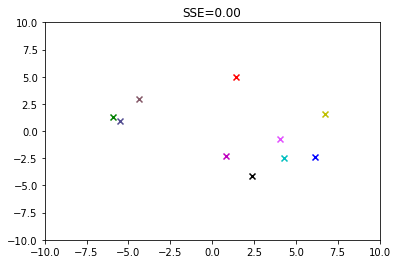

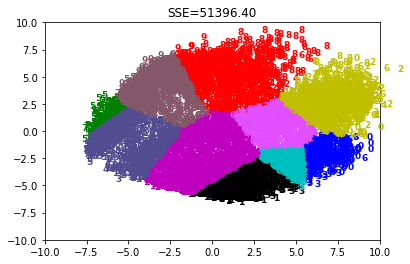

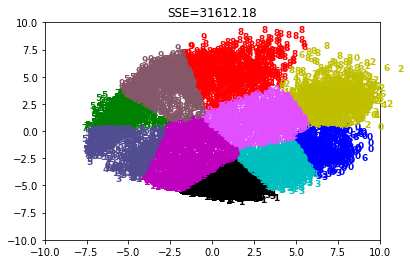

In [9]:
# 训练数据
test_i, test_l = dataset(batch_size=10000)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)  
    coord = tf.train.Coordinator() 
    threads=tf.train.start_queue_runners(sess=sess,coord=coord)
    test_i, test_l = sess.run([test_i, test_l])
    test_i = change(test_i)
    test_l = change(test_l)
    # 调用PCA进行降维
    low_d_feat, recon_mat = pca(test_i, 2) # 只取最重要的2个特征
    X=low_d_feat
    coord.request_stop()
    coord.join(threads)
# 实现k-means及其可视化
X = low_d_feat
y = test_l.argmax(axis=1)
#依次画出迭代1次、2次、3次的图
for max_iter in range(3):
    #设置参数
    n_clusters = 10
    initCent = X[50:60] #将初始质心初始化为X[50:60]
    #训练模型
    clf = KMeans(n_clusters,initCent,max_iter)
    clf.fit(X)
    cents = clf.centroids
    labels = clf.labels
    sse = clf.sse
    #画出聚类结果，每一类用一种颜色
    colors = ['b','g','r','k','c','m','y','#e24fff','#524C90','#845868']
    for i in range(n_clusters):
        index = np.nonzero(labels==i)[0]
        x0 = X[index,0]
        x1 = X[index,1]
        y_i = y[index]
        # 定义质心颜色位置
        for j in range(len(x0)):
            plt.text(x0[j],x1[j],str(int(y_i[j])),color=colors[i],\
                     fontdict={'weight': 'bold', 'size': 9})
        plt.scatter(cents[i,0],cents[i,1],marker='x',color=colors[i],linewidths=12)
    # 定义标题
    plt.title("SSE={:.2f}".format(sse))
    plt.axis([-10,10,-10,10])
    plt.show()